## Valeria 
###  Total-field Anomaly
#### Estimated Magnetic Moment on the equivalent layer with positive constraint 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cPickle as pickle
import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af

from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.gravmag.eqlayer import EQLGravity
from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang, contaminate, dircos
from fatiando.constants import G, SI2MGAL

C:\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
C:\Anaconda2\lib\site-packages\fatiando\vis\myv.py:53: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


In [2]:
from numpy import linalg
from scipy.optimize import nnls
from scipy.sparse import identity
from scipy.sparse import diags

In [3]:
def A_dipole(xi,yi,zi,xk,yk,zk):
    return A_dipole

# Load the synthetic model formed by one prism

In [4]:
with open('../data/model_single.pickle') as f:
        full_model = pickle.load(f)

In [5]:
inc, dec = full_model['geomag_field']
print inc, dec

6.0 -40.5


In [6]:
ints, incs, decs = vec2ang(full_model['model'][0].props['magnetization'])
print ints, incs, decs

10.0 30.0 -10.0


# Load the grid of points

In [7]:
with open('../data/regular_grid.pickle') as f:
        regular_grid = pickle.load(f)

In [8]:
regular_grid

{'DS': 41649.31278633903,
 'N': 2500,
 'area': [-5000, 5000, -5000, 5000],
 'metadata': 'Generated by computation_points.ipynb on 10 April 2018 19:38:20 UTC',
 'shape': (50, 50),
 'spacing': [204.08163265306123, 204.08163265306123]}

# Define the coordinates on the observation surface


In [9]:
#coordinates x and y of the data
xp, yp = regular(regular_grid['area'], regular_grid['shape'])
print len(xp)

#vertical coordinates of the data 
#zp = af.observation_surface(xp,yp)

# vertical coordinates of the data
zp = np.zeros_like(xp)
height_obs = -50.

print len(zp)

assert (xp.size == regular_grid['N']) and (yp.size == regular_grid['N']) and (zp.size == regular_grid['N']),  \
                'xp and yp and zp must have the same size difined by shape'


2500
2500


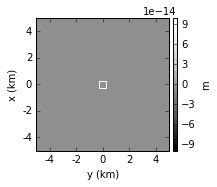

In [10]:
file_name = '..\\figs\\Data_Surface'

af.plotmap(xp, yp, zp, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'm')

plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

# Observed total-field anomaly

In [11]:
#tf_noise = 5.
tf_noise = 0.

In [12]:
tf = contaminate(prism.tf(xp,yp,zp,full_model['model'], inc, dec), tf_noise, seed=47)

..\figs\Total_Field


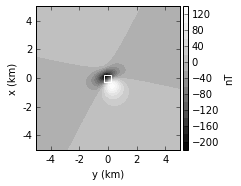

In [13]:
file_name = '..\\figs\\Total_Field'

print file_name

af.plotmap(xp, yp, tf, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'nT')

plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

# Observerd Gravity data

In [14]:
gz_noise = 0.01

In [15]:
gz = contaminate(prism.gz(xp,yp,zp,full_model['model']), gz_noise, seed=47)

..\figs\Gravity_data


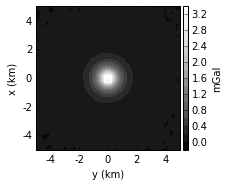

In [16]:
file_name = '..\\figs\\Gravity_data'

print file_name

af.plotmap(xp, yp, gz, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'mGal')

plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

### Planar equivalent layer

#### Parameters defining the equivalent layer

In [17]:
#horizontal plane containing the equivalent sources
z0 = np.zeros_like(zp)
h = 700.
z0 += h
print h

700.0


# Estimated magnetic moment distribution

In [18]:
#equivalent layer
layer = PointGrid(regular_grid['area'], h, regular_grid['shape'])

In [19]:
print len(xp), len(tf), inc, dec, incs, decs

2500 2500 6.0 -40.5 30.0 -10.0


# Sensitivity Matrix (dipoles) via Fatiando 

In [20]:
mag = dircos(incs, decs)
print mag

[0.85286853195244328, -0.15038373318043527, 0.49999999999999983]


In [21]:
Npts = regular_grid['N']
M    = Npts
TF_Fatiando = np.empty((Npts,M),dtype =float)
for i, c in enumerate(layer):
    TF_Fatiando[:,i] = sphere.tf(xp, yp, zp, [c], inc, dec,pmag=mag)
   

In [22]:
ATA = np.empty((M,M),dtype =float)
ATA = np.dot(np.transpose(TF_Fatiando),TF_Fatiando)

In [23]:
reg_parameter = 0.0000000000000000000001

Hessiana  = ATA + diags([reg_parameter], 0, (M,M), format='csr', dtype='float')

In [24]:
ATdo = np.dot(np.transpose(TF_Fatiando),tf)

In [25]:
p = linalg.solve(Hessiana,ATdo)


In [26]:
tf_predicted  = np.dot(TF_Fatiando,p)
residual        = tf - tf_predicted

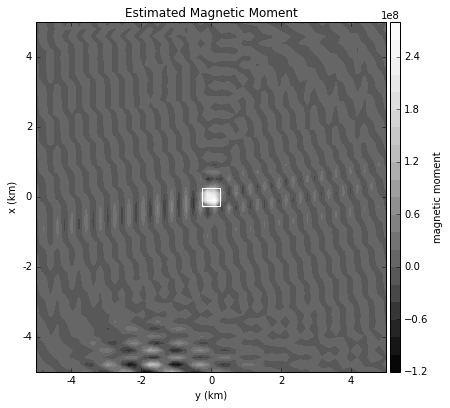

In [27]:
file_name = '..\\figs\\Estimated_Mag'

nplots = 1

f, (ax1) = plt.subplots(nplots,figsize=(6.33333,nplots*6.66667))
plt.title('Estimated Magnetic Moment')

af.multiplotmap(ax1, xp, yp, p, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'magnetic moment')


plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

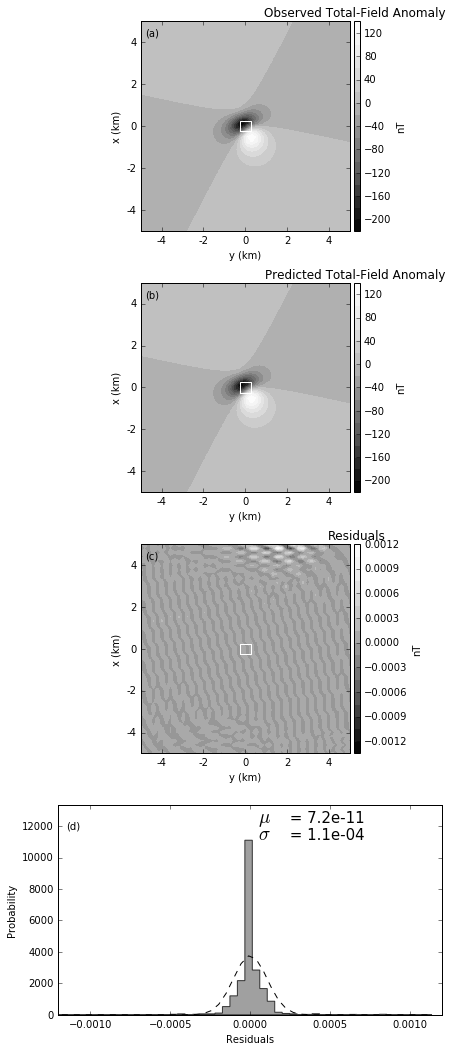

In [28]:
file_name = '..\\figs\\Predicted_Mag_Eq_Layer'

nplots = 4

f, (ax1, ax2, ax3, ax4) = plt.subplots(nplots,figsize=(6.33333,nplots*3.66667))


af.multiplotmap(ax1, xp, yp, tf, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'nT', 
                figure_label = '(a)')

plt.title('Observed Total-Field Anomaly ')


af.multiplotmap(ax2, xp, yp, tf_predicted, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'nT', 
                figure_label = '(b)')

plt.title('Predicted Total-Field Anomaly ')

af.multiplotmap(ax3, xp, yp, residual, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'nT', 
                figure_label = '(c)')

plt.title('Residuals')


af.multiplothist(ax4, residual, text_position = [0.52, 0.92, 0.84, 0.07],
                 text_fontsize = 15,
                 figure_label = '(d)', label_position = (0.02,0.89))


plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

# Sensitivity Matrix (point of masses) via Fatiando 

In [29]:
GZ_Fatiando = np.empty((Npts,M),dtype =float)
for i, c in enumerate(layer):
    GZ_Fatiando[:,i] = sphere.gz(xp, yp, zp, [c], dens = 1.0 )
   

In [30]:
ATA = np.empty((M,M),dtype =float)
ATA = np.dot(np.transpose(GZ_Fatiando),GZ_Fatiando)

In [31]:
reg_parameter = 0.000000000000000000001

Hessiana  = ATA + diags([reg_parameter], 0, (M,M), format='csr', dtype='float')

In [32]:
ATdo = np.dot(np.transpose(GZ_Fatiando),gz)

In [33]:
p_gz = linalg.solve(Hessiana,ATdo)

In [34]:
gz_predicted    = np.dot(GZ_Fatiando,p_gz)
residual        = gz - gz_predicted

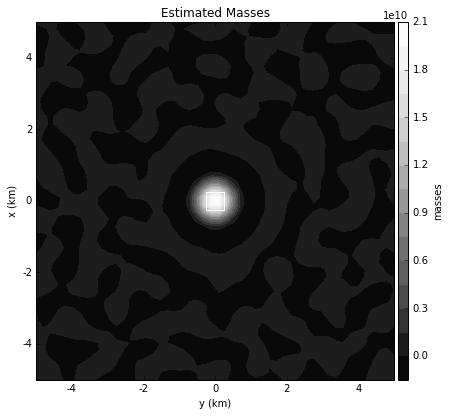

In [35]:
file_name = '..\\figs\\Estimated_Masses'

nplots = 1

f, (ax1) = plt.subplots(nplots,figsize=(6.33333,nplots*6.66667))
plt.title('Estimated Masses')

af.multiplotmap(ax1, xp, yp, p_gz, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'masses')


plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

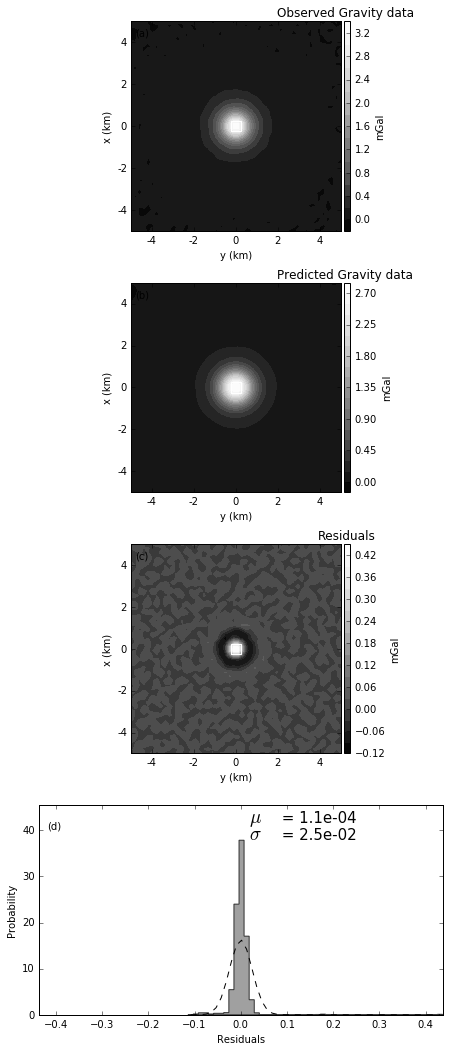

In [36]:
file_name = '..\\figs\\Predicted_Grav_Eq_Layer'

nplots = 4

f, (ax1, ax2, ax3, ax4) = plt.subplots(nplots,figsize=(6.33333,nplots*3.66667))


af.multiplotmap(ax1, xp, yp, gz, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'mGal', 
                figure_label = '(a)')

plt.title('Observed Gravity data ')


af.multiplotmap(ax2, xp, yp, gz_predicted, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'mGal', 
                figure_label = '(b)')

plt.title('Predicted Gravity data ')

af.multiplotmap(ax3, xp, yp, residual, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'mGal', 
                figure_label = '(c)')

plt.title('Residuals')


af.multiplothist(ax4, residual, text_position = [0.52, 0.92, 0.84, 0.07],
                 text_fontsize = 15,
                 figure_label = '(d)', label_position = (0.02,0.89))


plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

# Calculate the masses from the estimated masses using the equivalent layer

In [37]:
Total_Mass_Eq = np.sum(p_gz)

print 'The Total Mass via Equivalent Layer = %10.3e kg' % Total_Mass_Eq

The Total Mass via Equivalent Layer =  2.667e+11 kg


### Getting the TRUE mass of the simulated prism (synthetic_model_Single_prism.ipynb)


In [38]:
Massa_Total = full_model['mass_model']
print 'Total Mass of the True prism = %10.3e kg  ' %  Massa_Total

Total Mass of the True prism =  2.670e+11 kg  


#### Difference between the true mass of the simulated prism and the mass computed via Equivalent layer

In [39]:
print 'difference = %10.3e kg' % (Massa_Total - Total_Mass_Eq)

#Percentage of the Total_Mass_Eq

percent_mass = (Total_Mass_Eq * 100.)/Massa_Total 
print 'Percentage of the estimated mass by the Total mass Total_Mass_Eq = %4.2f'% percent_mass,'%'
#Percentage of the error
percent_error = ((Massa_Total - Total_Mass_Eq) * 100.)/Massa_Total 
print 'Percentage of the error = %4.2f'% percent_error,'%'

difference =  3.474e+08 kg
Percentage of the estimated mass by the Total mass Total_Mass_Eq = 99.87 %
Percentage of the error = 0.13 %


# Using the Equivalent Layer From Fatiando

In [40]:
# misfit function
misfit = EQLGravity(xp, yp, zp, gz, layer)

In [41]:
# normalizing factor
f0 = np.trace(misfit.hessian(None))/misfit.nparams
print 'f0 = %10.3e' % f0

f0 =  6.405e-21


In [42]:
# Tikhonov regularization
#regul = Damping(layer.size)
regul = Smoothness2D(layer.shape)

In [43]:
# Use the L-curve to find the best regularization parameter
solver = LCurve(misfit, regul, [f0*(10.**i) for i in range(-10, -1)]).fit()

In [44]:
print 'u0 = %10.3e' % ((1./f0)*solver.regul_param_)

u0 =  1.000e-03


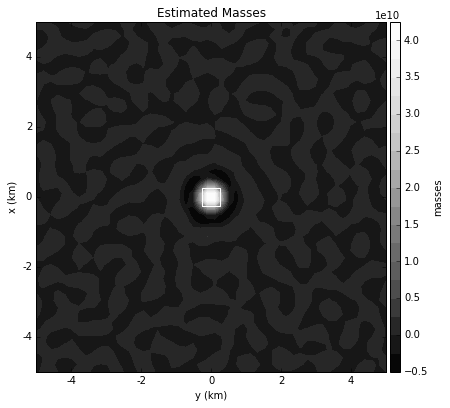

In [45]:

nplots = 1

f, (ax1) = plt.subplots(nplots,figsize=(6.33333,nplots*6.66667))
plt.title('Estimated Masses')

af.multiplotmap(ax1, xp, yp,solver.estimate_, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'masses')


plt.show()

In [46]:
Total_Mass_Eq2 = np.sum(solver.estimate_)
print 'The Total Mass via Equivalent Layer Fatiando = %10.3e kg' % Total_Mass_Eq2

The Total Mass via Equivalent Layer Fatiando =  2.664e+11 kg


In [48]:
print 'difference = %10.3e kg' % (Massa_Total - Total_Mass_Eq2)

#Percentage of the Total_Mass_Eq

percent_mass2 = (Total_Mass_Eq2 * 100.)/Massa_Total 
print 'Percentage of the estimated mass by the Total mass Total_Mass_Eq = %4.2f'% percent_mass2,'%'
#Percentage of the error
percent_error2 = ((Massa_Total - Total_Mass_Eq2) * 100.)/Massa_Total 
print 'Percentage of the error = %4.2f'% percent_error2,'%'

difference =  6.009e+08 kg
Percentage of the estimated mass by the Total mass Total_Mass_Eq = 99.77 %
Percentage of the error = 0.23 %


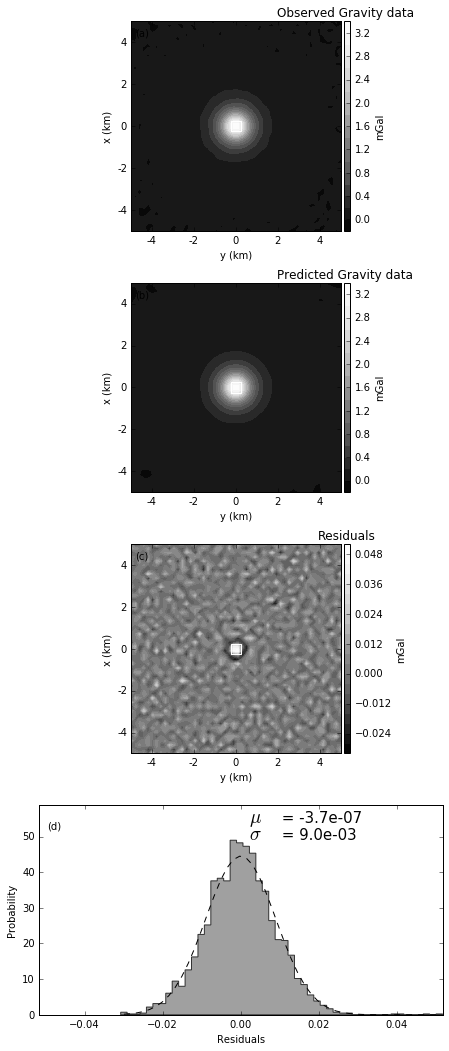

In [47]:
file_name = '..\\figs\\Predicted_Grav_Eq_Layer'

nplots = 4

f, (ax1, ax2, ax3, ax4) = plt.subplots(nplots,figsize=(6.33333,nplots*3.66667))


af.multiplotmap(ax1, xp, yp, gz, regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'mGal', 
                figure_label = '(a)')

plt.title('Observed Gravity data ')


af.multiplotmap(ax2, xp, yp, solver[0].predicted(),regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'mGal', 
                figure_label = '(b)')

plt.title('Predicted Gravity data ')

af.multiplotmap(ax3, xp, yp, solver[0].residuals(), regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'mGal', 
                figure_label = '(c)')

plt.title('Residuals')


af.multiplothist(ax4, solver[0].residuals(), text_position = [0.52, 0.92, 0.84, 0.07],
                 text_fontsize = 15,
                 figure_label = '(d)', label_position = (0.02,0.89))


#plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

## Estimate the magnetic moment over the equivalent layer with the positive constraint on the parameters 
### non-negative least squares problem (NNLS)

p_positive = nnls(Hessiana, ATdo)


print 'Norm-L2:', p_positive[1]

nplots = 1

f, (ax1) = plt.subplots(nplots,figsize=(6.33333,nplots*6.66667))

af.multiplotmap(ax1, xp, yp, p_positive[0], regular_grid['shape'], regular_grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'magnetic moment')

#plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()